# Solving the Incompressible Semi-Geostrophic Problem in 2D

First load in the neccessary packages and paths.

In [2]:
import initialconditions as ic
import matplotlib.pyplot as plt

import main as main
import sys
sys.path.append("/home/s2250115/petsc/arch-linux-c-debug/lib")

import animators as ani

Now set up the initial condition and visualize it.

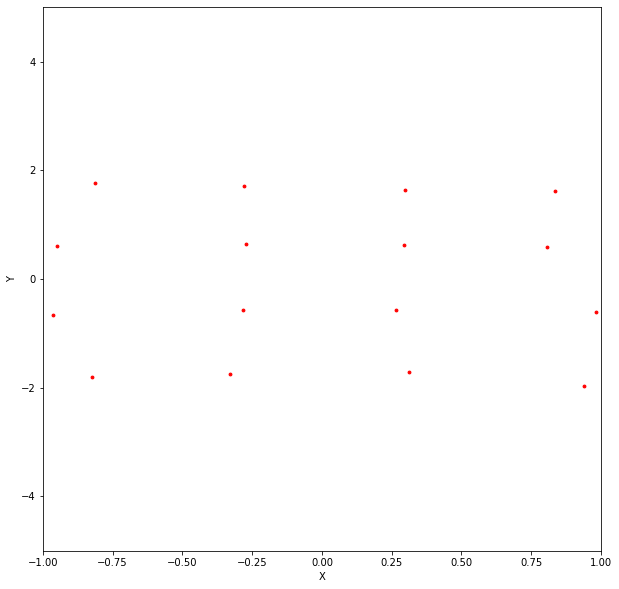

In [4]:
# Define the parameters of the system
N = 16 #Number of seeds
box = [-1, -2, 1, 2] #list or tuple defining domain [xmin, ymin, xmax, ymax]
per_tol = 1e-3 #Percent tolerance
periodic_x = False # Set the periodicity of X
periodic_y = True # Set the periodicity of Y
a = 1 # Set the replication parameter
tf = 10 #Final time
Ndt = 1000 #Number of timesteps

#Initialize initial condition
Z = ic.create_initial(N, -1, -2, 1, 2, 'lattice') 

#Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(Z[:,0], Z[:,1], color= 'red', s = 8)
ax.set_xlim([-1, 1])
ax.set_ylim([-5, 5])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

Solve the problem and save the data

In [5]:
main.SG_solver(box, Z, N, per_tol, tf, Ndt, periodic_x, periodic_y, a) #Solve and save the solution

Difference in initial and final weights 478.1306522357606
Difference in initial and final weights 6.893880531735838
Difference in initial and final weights 3.7307036931231203
2
Difference in initial and final weights 3.9818436556814882
3
Difference in initial and final weights 3.746221379691943
4
Difference in initial and final weights 3.5524153824763367
5
Difference in initial and final weights 116724828066265.6
6
Difference in initial and final weights 3.769431929970888
7
Difference in initial and final weights 3.7951073118482705
8
Difference in initial and final weights 3.818438320281357
9
Difference in initial and final weights 3.547948281530737
10
Difference in initial and final weights 14291671157.050661
11
Difference in initial and final weights 2.4474342702826046
12
Difference in initial and final weights 5.704686466137585
13
Difference in initial and final weights 15.94137256754703
14
Difference in initial and final weights 1345.0068860408423
15
Difference in initial and final

: 

: 

Animate the solutions

In [ ]:
ani.point_animator('./SG_data.npz', 'C', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' 
ani.point_animator('./SG_data.npz', 'Z', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' 
#ani.cell_animator('./SG_data.npz', box)

# Code for experimenting with impelementing periodicity

In [2]:
import scipy.io
import numpy as np

initialdata = scipy.io.loadmat('test_case.mat')

Z_test_1 = initialdata['Z_test'][:,:,0]
Z_test_2 = initialdata['Z_test'][:,:,1]
Z_test_3 = initialdata['Z_test'][:,:,2]
amp = initialdata['amp'][0][0]
bx = initialdata['bx'][0]
f = initialdata['f'][0][0]
g = initialdata['g'][0][0]
M = initialdata['M']
Nsq = initialdata['Nsq'][0][0]
s = initialdata['s'][0][0]
th0 = initialdata['th0'][0][0]
w_test_1 = initialdata['w_test'][:,0]
w_test_2 = initialdata['w_test'][:,1]
w_test_3 = initialdata['w_test'][:,2]

In [5]:
from pysdot.domain_types import ConvexPolyhedraAssembly
from pysdot import OptimalTransport
from pysdot import PowerDiagram
import numpy as np
import pyvista as pv
import weightguess as wg

nb_diracs = 2678

positions = Z_test_2
masses =  M[0]

domain = ConvexPolyhedraAssembly()
domain.add_box([bx[0], bx[1]], [bx[2], bx[3]])
box = bx
psi = np.zeros(shape = (nb_diracs,))

# we have to specify that dirac masses because by default, sdot takes ones * measure( domain ) / nb_diracs
# and that's not what we want in this case
w0 = w_test_2
ot = OptimalTransport( positions = positions, domain = domain, masses = masses, weights = w0 )

# first arg of add_replication is a translation
#for x in [ -1, 1 ]:
#    ot.pd.add_replication( [ x, 0 ] )

ot.adjust_weights()

filename = 'pb.vtk'
ot.pd.display_vtk( 'pb.vtk' )

20449706054.02648
[       0.          2449168.21053472 26470628.3356258  ...
  3322241.45047258  2150871.11318154  5028115.70942062]


/home/s2250115/.local/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


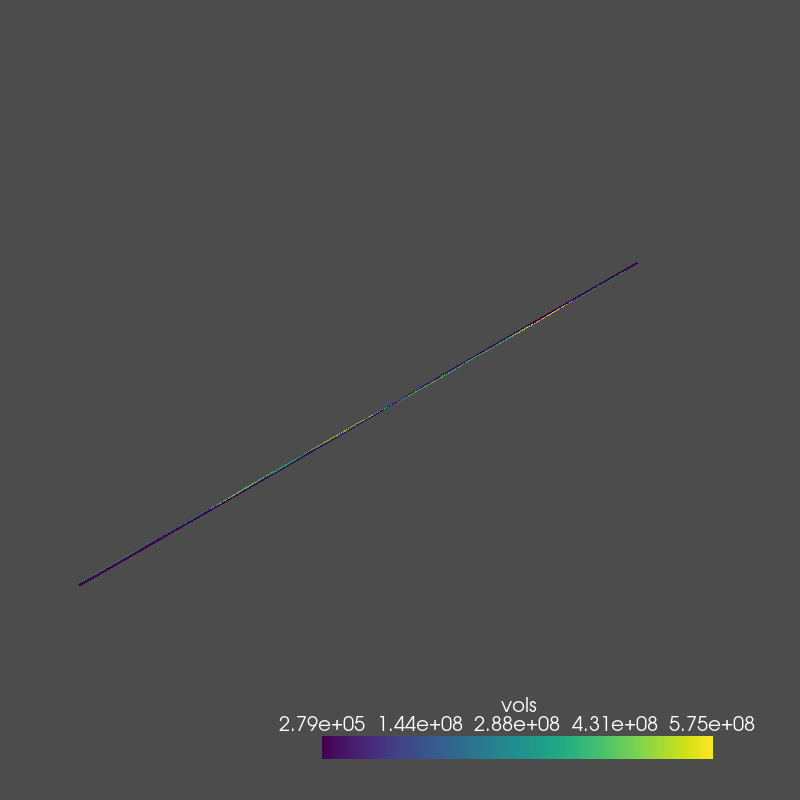

In [6]:
# Mass of cells
vols=ot.pd.integrals()
print(sum(vols))
print(vols)

# Read the data
grid=pv.read(filename)

# create cell data that gives the cell volumes, this allows us to colour by cell volumes
cell_vols = vols[grid.cell_data['num'].astype(int)]
grid.cell_data['vols']=cell_vols

# plot the data with an automatically created plotter, for a static picture use backend='static'
plotter = pv.Plotter(window_size=[800,800], notebook = True, off_screen=False)
plotter.add_mesh(grid)

# Render the frame
plotter.show()

In [ ]:
import matplotlib.pyplot as plt

#Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(Z_test_3[:,0], Z_test_3[:,1], color= 'red', s = 8)
ax.set_xlim([-1000000, 1000000])
ax.set_ylim([-3000000, 30000000])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [ ]:
print(bx)